## Описание проекта
Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.
Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

## Шаг 1. Откройте файл с данными и изучите общую информацию
Путь к файлу: /datasets/logs_exp.csv. Скачать датасет

In [1]:
import pandas as pd
import numpy as np
import math as mth
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy import stats as st

pd.options.display.float_format = '{:.2f}'.format
plt.style.use('seaborn-deep')

In [2]:
pip install -U seaborn

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.1)
Note: you may need to restart the kernel to use updated packages.


In [3]:
try: 
    df = pd.read_csv('logs_exp.csv', sep='\t') 

except FileNotFoundError:
    df = pd.read_csv('/datasets/logs_exp.csv', sep='\t') # яндексовский путь

In [4]:
df.info() # вывод общей информации
df.sample(5, random_state=1) # вывод 10 рандомных строк

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
120873,MainScreenAppear,9096061512161785646,1564917596,248
4103,OffersScreenAppear,1074933668878523996,1564631437,247
92724,OffersScreenAppear,8115340604306569112,1564838447,246
128891,CartScreenAppear,3163109716415429772,1564930563,246
186942,OffersScreenAppear,2405626918155135838,1565082344,247


Данные содержат информацию о 244 тысячях логов. Каждая запись в логе — это действие пользователя, или событие. 
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события, его необходимо будет привести к временному типу.
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Шаг 2. Подготовьте данные

#### Замените названия столбцов на удобные для вас; Проверьте пропуски и типы данных. Откорректируйте, если нужно; Добавьте столбец даты и времени, а также отдельный столбец дат;

In [5]:
df.columns=df.columns.str.lower()

In [6]:
df.isna().mean() # вывод среднего количества пропущенных значений

eventname        0.00
deviceidhash     0.00
eventtimestamp   0.00
expid            0.00
dtype: float64

In [7]:
df=df.rename(columns={'eventname': 'event', 'deviceidhash' : 'user_id', 'eventtimestamp':'timestamp', 'expid':'group'})

In [8]:
print('duplicates:', df.duplicated().sum()) # вывод количества дубликатов

duplicates: 413


In [9]:
df=df.drop_duplicates() #  удалим дубликаты

In [10]:
# преобразование данных о времени
df['date'] = pd.to_datetime(df['timestamp'],unit="s")

In [11]:
df.loc[df['group'] == 246, 'group'] = 1 
df.loc[df['group'] == 247, 'group'] = 2 
df.loc[df['group'] == 248, 'group'] = 99 

In [12]:
df['day']=pd.to_datetime(df['date']).dt.date 

In [13]:
df['day'] = df['day'].astype('datetime64[D]')

In [14]:
df['event'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [15]:
df['group'].unique()

array([ 1, 99,  2])

Мы обнаружили 413 дубликатов, скороее всего они вызваны ошибкой выгрузки, но их совсем немного, они были удалены. Пропуски в данных отсутствуют.
Мы привели названия столбцов к коректному виду, поменяли названия групп для удобства. Также мы проверили наличие дубликатов в названиях событий, и группах. Данные о времени событий приведены к коректному типу и созданы столбцы с днем и временем совершения события.

## Шаг 3. Изучите и проверьте данные
Сколько всего событий в логе?
Сколько всего пользователей в логе?
Сколько в среднем событий приходится на пользователя?
Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?
Много ли событий и пользователей вы потеряли, отбросив старые данные?
Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [16]:
print('всего разных видов событий:', df['event'].nunique())

всего разных видов событий: 5


In [17]:
print('всего событий в логе:', df['event'].count())

всего событий в логе: 243713


In [18]:
print('всего пользователей в логе:', df['user_id'].nunique())

всего пользователей в логе: 7551


In [19]:
print('в среднем на пользователя приходится {:.2f} событий'.format(df['event'].count()/df['user_id'].nunique()))

в среднем на пользователя приходится 32.28 событий


In [20]:
# минимальная и максимальная дата 
print('минимальная дата:', df['date'].min())
print('максимальная дата:', df['date'].max())

минимальная дата: 2019-07-25 04:43:36
максимальная дата: 2019-08-07 21:15:17


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


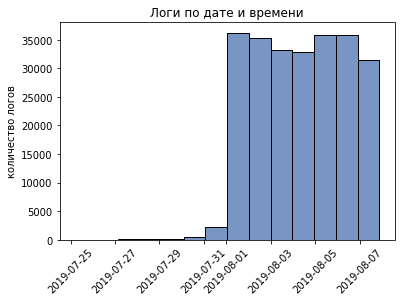

In [21]:
sns.histplot(df['date'], bins=14)
plt.title('Логи по дате и времени')
plt.xlabel('')
plt.ylabel('количество логов')
plt.xticks(rotation=45)
plt.show()    

In [22]:
logs_july=df[df['day']<='2019-7-31']['day'].count()/df['day'].count()*100

In [23]:
print('на 25-31 июля приходится {:.2f}% от всех имеющихся логов'.format(logs_july))

на 25-31 июля приходится 1.16% от всех имеющихся логов


In [24]:
users_july=df[df['day']<='2019-7-31']['user_id'].unique() 
users = df['user_id'].unique()

In [25]:
print('уникальных пользователей:', df['user_id'].nunique())

уникальных пользователей: 7551


In [26]:
print('уникальных пользователей, если исключить июль из анализа:', df[df['day']>'2019-7-31']['user_id'].nunique())

уникальных пользователей, если исключить июль из анализа: 7534


In [27]:
df_group=df.groupby(['group']).agg({'user_id':'nunique'})
df_group

,user_id
group,
1,2489
2,2520
99,2542


In [28]:
df_group['user_id'].sum() 

7551

Сумма уникальных пользователей по группам равна общему количеству уникальных пользователей, никто не попал в более, чем одну группу.

In [29]:
df=df[df['day']>='2019-8-01'] # исключаем июль из анализа
df_group=df.groupby(['group']).agg({'user_id':'nunique'}) # создаем еще раз таблицу уникумов по группам
df_group

,user_id
group,
1,2484
2,2513
99,2537


Исходя из того, что данные за первую неделю из двух имеющихся у нас в распоряжении, а именно за 25-31 июля, составляют 1.16% от всех имеющихся логов, мы решили их исключить, потеряв данные лишь о 17 пользователях, это 0.2%. 
Таким образом, мы будем анализировать данные с 1 по 7 августа.
Заметим, что в трех выделенных группах пользователи не повторяются.

## Шаг 4. Изучите воронку событий

#### Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

In [30]:
df_events=df.groupby('event')['event'].agg(['count'])
df_events['percent']=df_events['count']/df_events['count'].sum()*100
df_events.sort_values(by='percent', ascending=False)

,count,percent
event,,
MainScreenAppear,117328,48.71
OffersScreenAppear,46333,19.23
CartScreenAppear,42303,17.56
PaymentScreenSuccessful,33918,14.08
Tutorial,1005,0.42


У нас имеется пять событий, по частоте это: просмотр основной страницы, просмотр страницы с предложениями, страница оплаты, успешная оплата, а также тьюториал (инструкция по применению приложения).

#### Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [31]:
total_users=df['user_id'].nunique()
print('всего пользователей:',total_users)

всего пользователей: 7534


In [32]:
df_events_users=df.groupby('event')['user_id'] .agg(['nunique'])
df_events_users['percent_from_all']=df_events_users['nunique']/df['user_id'].nunique()*100
df_events_users=df_events_users.sort_values(by='percent_from_all', ascending=False)
df_events_users

,nunique,percent_from_all
event,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


Всего у нас было зафиксировано 7534 уникальных пользователей.  Однако самое популярное действие, - MainScreenAppear, совершили не все, а 7419 (98.5% от всех). Значит, некоторые пользователи пропустили это действие. Второе по популярности действие - OffersScreenAppear совершили 61% пользователей от всех. А вот Tutorial посмотрели только 11.2% пользователей.

####  Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

Через множества (в которых элементы не повторяются, а значит там только уникальные пользователи), проверим присутсвие одних и тех же пользователей в событиях.

In [33]:
MainScreen=set(df[df['event']=='MainScreenAppear']['user_id'])
OffersScreen=set(df[df['event']=='OffersScreenAppear']['user_id'])
CartScreen=set(df[df['event']=='CartScreenAppear']['user_id'])
PaymentScreen=set(df[df['event']=='PaymentScreenSuccessful']['user_id'])
Tutorial=set(df[df['event']=='Tutorial']['user_id'])

In [34]:
print('пользователей, пропустивших MainScreenAppear и совершивших сразу OffersScreenAppear: {} или {:.2f}%'.format(
    len(OffersScreen-MainScreen), len(OffersScreen-MainScreen)/total_users*100))

пользователей, пропустивших MainScreenAppear и совершивших сразу OffersScreenAppear: 111 или 1.47%


In [35]:
print('пользователей, пропустивших MainScreenAppear и OffersScreenAppear, и совершивших CartScreenAppear без них:', len(
    CartScreen-OffersScreen-MainScreen))

пользователей, пропустивших MainScreenAppear и OffersScreenAppear, и совершивших CartScreenAppear без них: 0


In [36]:
print('пользователей, пропустивших CartScreenAppear и совершивших сразу PaymentScreenSuccessful: {} или {:.2f}%'.format(
    len(PaymentScreen-CartScreen), len(PaymentScreen-CartScreen)/total_users*100))

пользователей, пропустивших CartScreenAppear и совершивших сразу PaymentScreenSuccessful: 5 или 0.07%


In [37]:
print('пользователей, пропустивших CartScreenAppear и OffersScreenAppear, и совершивших PaymentScreen без них: {} или {:.2f}%'.format(
    len(PaymentScreen-OffersScreen-CartScreen), len(PaymentScreen-OffersScreen-CartScreen)/total_users*100))

пользователей, пропустивших CartScreenAppear и OffersScreenAppear, и совершивших PaymentScreen без них: 0 или 0.00%


In [38]:
print(len(Tutorial-MainScreen))
print(len(Tutorial-MainScreen-OffersScreen))
print(len(Tutorial-CartScreen))
print(len(Tutorial-PaymentScreen))
print(len(Tutorial-CartScreen-PaymentScreen))

4
4
298
373
298


Мы предпологаем, что, как правило, первое событие, это MainScreenAppear, второе - OffersScreenAppear, однако, на него можно было попасть иногда минуя первое (так сделали 1.5% пользователей). Следующим действием был CartScreenAppear (его сделали прийдя с MainScreenAppear или OffersScreenAppear, там нет пользователей попавших на этот шаг без одного из предыдущих). 
Потом совершали PaymentScreenSuccessful, как правило прийдя с CartScreenAppear, однако 5 человек миновали его и пришли сразу с OffersScreenAppear (возможно, у них уже была привязана карта или платежная система).
Однако, не совсем понятно как обстоят дела с событием Tutorial, когда оно совершается.

In [39]:
users = df.pivot_table(index='user_id', columns='event', values='date', aggfunc='min')

In [40]:
# сделаем расчет, чтобы понять, когда большинство заходило на Tutorial - до или после MainScreenAppear
users_tutorial=users[users['Tutorial']==users['Tutorial']] # 840 users
users_tutorial_before_mainscreen = users_tutorial[users_tutorial['Tutorial']< users_tutorial['MainScreenAppear']] # 787 users
print('Пользователей, зашедших на Tutorial прежде чем зайти на MainScreenAppear : {} или {:.2f}%'.format(users_tutorial_before_mainscreen['Tutorial'].count(), users_tutorial_before_mainscreen['Tutorial'].count()/users_tutorial['Tutorial'].count()*100))


Пользователей, зашедших на Tutorial прежде чем зайти на MainScreenAppear : 787 или 93.69%


In [41]:
users_tutorial[users_tutorial['Tutorial']<users_tutorial['PaymentScreenSuccessful']].head()

event,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
user_id,,,,,
9841258664663090,2019-08-03 10:52:15,2019-08-03 10:47:59,2019-08-03 10:49:42,2019-08-03 17:57:27,2019-08-03 10:47:28
29094035245869447,2019-08-02 13:15:22,2019-08-02 13:13:24,2019-08-02 13:13:43,2019-08-02 15:23:05,2019-08-02 13:13:20
77364241990273403,2019-08-03 11:22:11,2019-08-02 15:08:00,2019-08-03 11:12:23,2019-08-03 11:22:10,2019-08-02 15:07:40
84107839139059565,2019-08-03 15:15:43,2019-08-03 15:13:41,2019-08-03 15:15:17,2019-08-03 15:16:18,2019-08-03 15:13:19
89078601045475920,2019-08-04 16:47:58,2019-08-04 16:46:29,2019-08-04 16:46:37,2019-08-04 16:47:57,2019-08-04 16:45:45


Мы можем сказать, что согласно нашим данным большинство (94%) совершали действие Tutorial до MainScreen. Тогда получается на Tutorial либо можно было попасть из внешнего источника, либо такой результат мог быть вызван сбоем или "скосом" в данных. Также, возможно, эти пользователи уже соврешали MainScreen в те дни, за которые у нас было очень мало данных и они были исключены из анализа.

Таким образом, стандартый порядок такой:

0. Tutorial (лучше исключить этот шаг для анализа воронки)
1. MainScreenAppear
2. OffersScreenAppear
3. CartScreenAppear
4. PaymentScreenSuccessful

#### По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B. На каком шаге теряете больше всего пользователей? Какая доля пользователей доходит от первого события до оплаты?

Так как в задании сказано не учитывать последовательность действий при расчете воронки, удалим событие Tutorial и рассчитаем простую воронку и пошаговою воронку.

In [42]:
df_events_users_funnel=df.groupby('event')['user_id'] .agg(['nunique']).sort_values(by='nunique', ascending=False)
df_events_users_funnel=df_events_users_funnel.drop(['Tutorial']).reset_index()
df_events_users_funnel

,event,nunique
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


In [43]:
df_events_users_funnel['percent_from_previos']= ""
for i in range(len(df_events_users_funnel['event'])):
    df_events_users_funnel['percent_from_previos'][0]=100
    df_events_users_funnel['percent_from_previos'][i+1]=df_events_users['nunique'][i+1]/df_events_users['nunique'][i]*100
    i+=1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [44]:
total_users_fisrt_event=df_events_users['nunique'][0]
df_events_users_funnel['percent_from_first']= df_events_users_funnel['nunique']/total_users_fisrt_event*100
df_events_users_funnel

,event,nunique,percent_from_previos,percent_from_first
0,MainScreenAppear,7419,100,100.00
1,OffersScreenAppear,4593,61.91,61.91
2,CartScreenAppear,3734,81.30,50.33
3,PaymentScreenSuccessful,3539,94.78,47.70


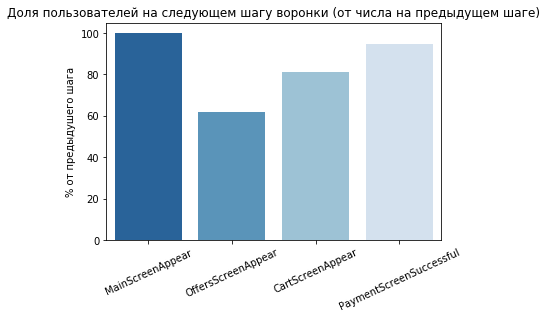

In [45]:
sns.barplot(y=df_events_users_funnel['percent_from_previos'], x=df_events_users_funnel['event'], palette='Blues_r')
plt.title('Доля пользователей на следующем шагу воронки (от числа на предыдущем шаге)')
plt.xlabel('')
plt.ylabel('% от предыдушего шага')
plt.xticks(rotation=25)
plt.show()

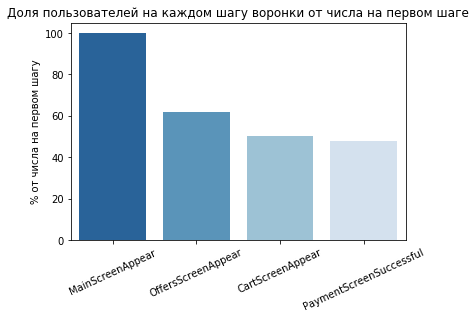

In [46]:
sns.barplot(y=df_events_users_funnel['percent_from_first'], x=df_events_users_funnel['event'], palette='Blues_r')
plt.title('Доля пользователей на каждом шагу воронки от числа на первом шаге')
plt.xlabel('')
plt.ylabel('% от числа на первом шагу')
plt.xticks(rotation=25)
plt.show()

Больше всего пользователей мы теряем пользователей после первого шага, - почти 40% из тех, кто посетил начальную страницу (MainScreenAppear) не переходят на страницу с предложениями (OffersScreenAppear). Значит, именно на этом этапе нужно что-то менять, чтобы больше пользователей шло на страницу с предложениями.

Из тех же, что перешли на предложения, более 80% идут на страницу оплаты (CartScreenAppear) и из них почти все, а именно 95% успешно оплачивают (PaymentScreenSuccessful).
От первого собятия до оплаты доходят чуть менее половины пользователей, - 48%.

## Шаг 5. Изучите результаты эксперимента

#### Сколько пользователей в каждой экспериментальной группе? Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247

In [47]:
df_group

,user_id
group,
1,2484
2,2513
99,2537


В трех группах практически одинаковое число уникальных пользователей, около 2500.

Для удобства, добавим в названия действий цифру, обозначающую порядковый номер выполнения. Тьюториал оставим без изменений, т.к. ранее мы видели, что он часто как событие предшествовал просмотру экрана. По этой причине мы не будем брать это действие в расчет.

In [48]:
df['event'] = df['event'].str.replace('MainScreenAppear','1_MainScreenAppear')
df['event'] = df['event'].str.replace('OffersScreenAppear','2_OffersScreenAppear')
df['event'] = df['event'].str.replace('CartScreenAppear','3_CartScreenAppear')
df['event'] = df['event'].str.replace('PaymentScreenSuccessful','4_PaymentScreenSuccessful')

В теории по тестированию было сказано, что при анализе воронок надёжнее опираться на обычную конверсию (в том числе т.к. некоторые шаги иногда могут быть пропущены), а не конверсию из одного шага в другой. Поэтому в данной части мы будем рассматривать именно обычную конверсию. Таблица с общей конверсией выглядит так:

In [49]:
df_gr=df.groupby(['event'])['user_id'].agg(['nunique'])
df_gr['conver']=df_gr['nunique']/df_gr['nunique'].max()*100
df_gr=df_gr.drop(['Tutorial']).reset_index()
df_gr

,event,nunique,conver
0,1_MainScreenAppear,7419,100.00
1,2_OffersScreenAppear,4593,61.91
2,3_CartScreenAppear,3734,50.33
3,4_PaymentScreenSuccessful,3539,47.70


Разобъем общую таблицу по трем группам.

In [50]:
groups=df.pivot_table(index='event', columns='group', values='user_id', aggfunc='nunique')
groups=groups.drop(['Tutorial'])#.reset_index()
groups=groups.rename(columns={1:'control_1', 2:'control_2', 99:'experimental'})
groups

group,control_1,control_2,experimental
event,,,
1_MainScreenAppear,2450,2476,2493
2_OffersScreenAppear,1542,1520,1531
3_CartScreenAppear,1266,1238,1230
4_PaymentScreenSuccessful,1200,1158,1181


Проверим, находят ли статистические критерии разницу между контрольными группами (А/А). Если разбивка выполнена верно, то разницы между группами быть не должно. Наша нулевая гипотеза будет звучать как на каждом шаге "между конверсиями (долями) нет разницы". То есть нет статистически значимой разницы между долями группы 1 и 2: 
1) тех, кто перешел на страницу предложений к общему количеству пользователей в группе (те кто были на начальной странице) 
2) тех кто перешел на страницу оплаты от тех, к общему количеству пользователей в группе
3) тех, кто успешно оплатил к общему количеству пользователей в группе

Альтернативная гипотеза, соответственно будет звучать, как есть статистически значимая разница между долями в группах по каждой из конверсий.

In [51]:
alpha = .05 # критический уровень статистической значимости

In [52]:
# пропорция успехов в первой группе:
p1 = groups['control_1']['2_OffersScreenAppear']/groups['control_1']['1_MainScreenAppear']

# пропорция успехов во второй группе:
p2 = groups['control_2']['2_OffersScreenAppear']/groups['control_2']['1_MainScreenAppear']

# пропорция успехов во второй группе:
p_combined = (groups['control_1']['2_OffersScreenAppear'] + groups['control_2']['2_OffersScreenAppear']) / (
    groups['control_1']['1_MainScreenAppear'] + groups['control_2']['1_MainScreenAppear'])

# разница пропорций в датасетах
difference = p1 - p2

In [53]:
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(
    p_combined * (1 - p_combined) * (1 / groups['control_1']['1_MainScreenAppear'] + 1 / groups['control_2']['1_MainScreenAppear'])
)

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.2622344959255778
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Первое сравнение показало, что нет оснований полагать о разнице между группами. Посмотрим на остальные, для этого создадим фунцию

In [54]:
def test(group_a, group_b, event):
    p1 = groups[group_a][event]/groups[group_a]['1_MainScreenAppear']
    p2 = groups[group_b][event]/groups[group_b]['1_MainScreenAppear']
    p_combined = (groups[group_a][event] + groups[group_b][event]) / (
    groups[group_a]['1_MainScreenAppear'] + groups[group_b]['1_MainScreenAppear'])
    difference = p1 - p2
    z_value = difference / mth.sqrt(
    p_combined * (1 - p_combined) * (1 / groups[group_a]['1_MainScreenAppear'] + 1 / groups[group_b]['1_MainScreenAppear']))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [ ]:
# проверим работу функции повторив предыдущее сравнение
test('control_1', 'control_2', '2_OffersScreenAppear')

In [56]:
test('control_1', 'control_2', '3_CartScreenAppear')

p-значение:  0.24012327015939383
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [57]:
test('control_1', 'control_2', '4_PaymentScreenSuccessful')

p-значение:  0.12044299485641763
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Итак, мы не нашли статистически значимую разницу между контрольными группами, сравнивая их конверсии. Это хорошие новости, значит, мы можем по-прежнему считать, что группы являются контрольными.

#### Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно? Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию.

Cнова выведем таблицу groups, добавив столбцы с простой конверсией для кажой группы. 

In [58]:
groups['conver_1']=groups['control_1']/groups['control_1'].max()*100
groups['conver_2']=groups['control_2']/groups['control_2'].max()*100
groups['conver_experiment']=groups['experimental']/groups['experimental'].max()*100
groups

group,control_1,control_2,experimental,conver_1,conver_2,conver_experiment
event,,,,,,
1_MainScreenAppear,2450,2476,2493,100.00,100.00,100.00
2_OffersScreenAppear,1542,1520,1531,62.94,61.39,61.41
3_CartScreenAppear,1266,1238,1230,51.67,50.00,49.34
4_PaymentScreenSuccessful,1200,1158,1181,48.98,46.77,47.37


Самое популярное событие - OffersScreenAppear, заход на страницу. В кадой группе это событие совершило 62.94 и 61.39, в экспериметальной - 61.41%.
Мы уже заключили, что между контрольными группами нельзя утверждать о разнице этих долей, и что, таким образом, разбиение работает корректно.
Проведем теперь тесты А/B для каждого события и обеих контрольных групп. Снова нулевая гипотеза будет утвержать о равенстве долей.

In [59]:
test('control_1', 'experimental', '2_OffersScreenAppear')

p-значение:  0.2684281587249231
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [60]:
test('control_2', 'experimental', '2_OffersScreenAppear')

p-значение:  0.9869365252844515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По конверсии во второй шаг мы не можем говорить о разнице между экспериментальной и какой-либо из контрольных групп.

In [61]:
test('control_1', 'experimental', '3_CartScreenAppear')

p-значение:  0.1006104270048993
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [62]:
test('control_2', 'experimental', '3_CartScreenAppear')

p-значение:  0.6408180183192491
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По конверсии в третий шаг (доле тех, кто перешел на страницу оплаты ко всем пользователям,  зашедшим на основную страницу) мы также не можем говорить о разнице между экспериментальной и какой-либо из контрольных групп.

In [63]:
test('control_1', 'experimental', '4_PaymentScreenSuccessful')

p-значение:  0.2582638437556217
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [64]:
test('control_2', 'experimental', '4_PaymentScreenSuccessful')

p-значение:  0.6699208079332859
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По конверсии в последний шаг мы снова не можем говорить о разнице между экспериментальной и какой-либо из контрольных групп  (доле тех, кто успешно оплатил, ко всем пользователям, зашедшим на основную страницу)


#### Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

Объединим первую и вторую группы, чтобы создать  объединённую контрольную группу.

In [65]:
groups['control_united']=groups['control_1']+groups['control_2']
groups['conver_united']=groups['control_united']/groups['control_united'].max()*100
groups

group,control_1,control_2,experimental,conver_1,conver_2,conver_experiment,control_united,conver_united
event,,,,,,,,
1_MainScreenAppear,2450,2476,2493,100.00,100.00,100.00,4926,100.00
2_OffersScreenAppear,1542,1520,1531,62.94,61.39,61.41,3062,62.16
3_CartScreenAppear,1266,1238,1230,51.67,50.00,49.34,2504,50.83
4_PaymentScreenSuccessful,1200,1158,1181,48.98,46.77,47.37,2358,47.87


Проведем те же тесты для объединенной контрольной и экспериментальной групп.

In [66]:
test('control_united', 'experimental', '2_OffersScreenAppear')

p-значение:  0.5308589432077624
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [67]:
test('control_united', 'experimental', '3_CartScreenAppear')

p-значение:  0.22404678803657152
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [68]:
test('control_united', 'experimental', '4_PaymentScreenSuccessful')

p-значение:  0.6863094718086811
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


И в этом случае также нам не удалось опровергнуть ни одну из нулевых гипотез для конверсий, т.е. мы не можем говорить о разнице долей объединенной контрольной и экспериментальной групп.

#### Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

Мы брали уровень значимости 0.05. Мы сделали 12 проверок (3 A1/A2, 3 A1/B, 3 A2/B, 3 (A1+A2)/B). Ни в одном из тестов p-значение не опускалось ниже 0.1 (а часто было гораздо выше). В данном случае мы можем оставить наш уровень значимости, однако, можно было установить его и еще ниже, 0.01.

Заметим, что чем больше групп в тесте, тем чаще хотя бы при одном сравнении получается ложнопозитивный результат. То есть в нашем случае речь идет о множественном тесте, и с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода.

Однако у нас нет позитивных результатов ни по одному из тестирований. В противном случае, необходимо было бы применить метод метод Бонферрони (из-за простоты решения, но возможно, как варианты еще и Холма или Шидака), чтобы снизить групповую вероятность ошибки первого рода и скорректировать требуемые уровни значимости.

### Выводы

Подведем итоги. 
Мы проанализировали данные за первую неделю августа (1-7 августа 2019) по логам пользователей мобильного приложения, исключив данные за последнюю неделю июля т.к. их было чуть больше 1% от всех данных. 
Всего у нас оказалось в распоряжении более 240 тысяч логов, которые были совершены 7,5 тысячами уникальных пользователей.

Всего разных видов событий или действий было 5. В порядке убывания по частоте, это: просмотр основной страницы, просмотр страницы с предложениями, страница оплаты, успешная оплата, а также тьюториал (инструкция по применению приложения). В среднем на одного пользователя приходится около 32 события.

Последовательность действий в приложении- нестрогая, то есть некоторые шаги могут быть пропущены пользователем, но в большинстве случаев идет по стандартной схеме. Самое популярное действие, - просмотр основной страницы, совершили практически все - 98.5%. Второе по популярности действие (на него можно было попасть иногда минуя первое)  - просмотр страницы с предложениями, его совершили 61% пользователей от всех. И здесь мы теряли больше всего пользователей - почти 40% из тех, кто посетил начальную страницу не переходят на страницу с предложениями. Значит, для повышения конверсии необходимы изменения на этом этапе, чтобы больше пользователей заходило на страницу с предложениями.

Из зашедших на предложения , более 80% пользователей заходили на страницу оплаты, и после нее почти все, 95%, оказывались на странице об успешной покупке. От просмотра основной страницы до оплаты доходят чуть менее половины пользователей, - 48%.

Заметим, Tutorial посмотрели только 11.2% пользователей. При этом, по нашим данным, большинство пользователей заходили туда раньше, чем на основную страницу - в 94%. Это может быть связано с тем, что они могли заходить на самом деле на основную страницу раньше последней недели июля, но мы этого не можум проверить т.к. у нас нет данных. Или же сразу после скачивания приложения у пользователей открывался тьюториал, или же  отображение этого события некорректо по времени. Мы не стали включать тьюториал в дальшейший анализ из по эатим причинам.


Что касается тестирования нового шрифта приложения, - был проведен A/A/B-эксперимент. В трех группах было схожее практически число уникальных пользователей, около 2500. Для анализва рещультатов мы опирались на обычную конверсию, т.е. число пользователей соврешивших событие к числу пользователей соврешивших первой собятие (просмотр основной страницы). Наш анализ показал, что разбивка конрольных групп была сделана корректно. Так же наш анализ показал, что нет значимых статистических различий между конверсией контрольных групп и экспериментальной группы ни на одном из этапов, равно как и нет разницы между конверсиями объединённой контрольной группой и экспериментальной группой. По результатам теста нет разницы конвресий между группами со старым шрифтом и новым шрифтом. Это означает, что новый шрифт, предлагаемый дизайнерами не должен пагубно отразиться на конверсии вопреки опасениям менеджеров, и можно принять положительное решение о его изменении. 